<a href="https://www.kaggle.com/code/clemwo/olympic-games-deep-dive?scriptVersionId=196260681" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
IMPORT_ADDITIONAL = True
if IMPORT_ADDITIONAL:
    !pip install pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 64.2 MB/s eta 0:00:00


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)           

import re
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

sns.set(style="white")

/kaggle/input/olympic-games-1994-2024/PyeongChang 2018 Olympics Nations Medals.csv
/kaggle/input/olympic-games-1994-2024/Paris 2024 Olympics_Nations Medals.csv
/kaggle/input/olympic-games-1994-2024/Vancouver 2010 Olympics Nations Medals.csv
/kaggle/input/olympic-games-1994-2024/Beijing_2008_ Olympics_Nations_Medals.csv
/kaggle/input/olympic-games-1994-2024/Sochi 2014 Olympics Nations Medals.csv
/kaggle/input/olympic-games-1994-2024/London 2012 Olympics Nations Medals.csv
/kaggle/input/olympic-games-1994-2024/Lillehammer 1994 Olympics Nations Medals.csv
/kaggle/input/olympic-games-1994-2024/Atlanta 1996 Olympics Nations Medals.csv
/kaggle/input/olympic-games-1994-2024/Nagano 1998 Olympics Nations Medals.csv
/kaggle/input/olympic-games-1994-2024/Sydney 2000 Olympics Nations Medals.csv
/kaggle/input/olympic-games-1994-2024/Torino 2006 Olympics Nations Medals.csv
/kaggle/input/olympic-games-1994-2024/Tokyo 2020 Olympics Nations Medals.csv
/kaggle/input/olympic-games-1994-2024/SaltLakeCity 

![](https://study.com/cimages/multimages/16/olympics_logo.svg8175301616568861190.png)

# 📊Olympic Games 🌍 Deep-Dive🏅

> In this notebook we are going to investigate [Kaggles Olympic Games data](https://www.kaggle.com/datasets/youssefismail20/olympic-games-1994-2024) which contains medals 🥇🥈🥉 and performances 🏃‍🏊‍ across 3️⃣ decades. The data ranges from 1994 to 2024.

In [3]:
# ---------------------------------------- #
# Create dictionary with all olympics data #
# ---------------------------------------- #

_olympics = {} 

def extract_year(filename):
    filename_cleaned = filename.replace('_', ' ').replace('.csv', '')
    year = filename_cleaned.split(' ')[1]
    return year

def extract_city(filename):
    filename_cleaned = filename.replace('_', ' ').replace('.csv', '')
    city = filename_cleaned.split(' ')[0]
    return city

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.db'): continue
        
        file_path = os.path.join(dirname, filename)
        year = int(extract_year(filename))
        city = extract_city(filename)
        
        _olympics[(year, city)] = pd.read_csv(file_path)

year_city = pd.DataFrame([(key[0], key[1]) for key in _olympics.keys()], 
                         columns=['Year', 'City'])


# ----------------------------- #
# Get the country for each city #
# ----------------------------- #

geolocator = Nominatim(user_agent="olympics_geocoder")

def get_country(city):
    try:
        location = geolocator.geocode(city, language='en')
        if location:
            country = str(location).split(', ')[-1]
            if country == 'Russia': country = 'Russian Federation'
            elif country == 'South Korea': country = 'Korea, Republic of'
            return country
    except GeocoderTimedOut:
        return None
    return None

year_city['Country'] = year_city['City'].apply(lambda city: get_country(city))

# Manually set SaltLakeCity to United States. This didn't work with geolocator cause it's not split.
year_city.loc[year_city['City'] == 'SaltLakeCity', 'Country'] = 'United States'

# Set the country code and the country flag. 
year_city['CountryAlpha3'] = year_city['Country'].apply(lambda country: pycountry.countries.get(name=country).alpha_3)
year_city['CountryFlag'] = year_city['Country'].apply(lambda country: pycountry.countries.get(name=country).flag)


# --------- #
# Summarize #
# --------- #

print(f"Number of olympics: {len(year_city)}")
year_city = year_city.sort_values(by='Year', ascending=True).reset_index(drop=True)
year_city

Number of olympics: 16


,Year,City,Country,CountryAlpha3,CountryFlag
0,1994,Lillehammer,Norway,NOR,🇳🇴
1,1996,Atlanta,United States,USA,🇺🇸
2,1998,Nagano,Japan,JPN,🇯🇵
3,2000,Sydney,Australia,AUS,🇦🇺
4,2002,SaltLakeCity,United States,USA,🇺🇸
5,2004,Athens,Greece,GRC,🇬🇷
6,2006,Torino,Italy,ITA,🇮🇹
7,2008,Beijing,China,CHN,🇨🇳
8,2010,Vancouver,Canada,CAN,🇨🇦
9,2012,London,United Kingdom,GBR,🇬🇧


Now we got a clean dictionary with the year of the olympic games as the `key` and the actual dataframe as the `value`. Additionally, we got a dataframe which tells us in addition to the given year and city also the infered country of the games. Let's start investigating the actual data. 

In [4]:
# ---------------- #
# Global Variables #
# ---------------- #

class GlobalVars:
    ALL_YEARS = year_city['Year'].tolist()
    SUMMER_YEARS = [1996, 2000, 2004, 2012, 2016, 2020, 2024]
    WINTER_YEARS = [1994, 1998, 2002, 2006, 2010, 2014, 2018, 2022]

# 🌇 General Overview

In this section we are going to get a general overview on which cities and countries hosted the olympics, and how the attended countries are distributed over time.

In [5]:
example_year_city = tuple(year_city.iloc[14][['Year', 'City']].values)

_2024_paris = _olympics.get(example_year_city)
print(f"Rows: {_2024_paris.shape[0]:,}")
print(f"Cols: {_2024_paris.shape[1]:,}")
print(_2024_paris.dtypes)
_2024_paris.head(3)

Rows: 29
Cols: 5
NOC       object
Gold       int64
Silver     int64
Bronze     int64
Total      int64
dtype: object


,NOC,Gold,Silver,Bronze,Total
0,NOR,16,8,13,37
1,GER,12,10,5,27
2,USA,8,10,7,25


For the example Olympics in Paris 2024 we see the `Gold`, `Silver` and `Bronze` metal counts as well as the `Total` medal counts for $91$ countries. Let's check if the rows and columns differ for all the olympics dataframes and let's add the number of countries attended. 

In [6]:
year_city['NrCountriesAttended'] = 0
validate_column_count = 5

for i in range(year_city.shape[0]): 
    year_city_tuple = tuple(year_city.iloc[i][['Year', 'City']].values)
    _year_city_olympics = _olympics.get(year_city_tuple)
    
    # Get and set the number of countries which attended the olympics for that year. 
    nr_countries_attended = _year_city_olympics.shape[0]
    year_city.loc[i, 'NrCountriesAttended'] = nr_countries_attended
    
    assert validate_column_count == _year_city_olympics.shape[1],\
        f"INCONSISTENCY_ERROR: {year_city_tuple} does not have {validate_column_count} columns!"
    
year_city

,Year,City,Country,CountryAlpha3,CountryFlag,NrCountriesAttended
0,1994,Lillehammer,Norway,NOR,🇳🇴,22
1,1996,Atlanta,United States,USA,🇺🇸,78
2,1998,Nagano,Japan,JPN,🇯🇵,24
3,2000,Sydney,Australia,AUS,🇦🇺,79
4,2002,SaltLakeCity,United States,USA,🇺🇸,24
5,2004,Athens,Greece,GRC,🇬🇷,74
6,2006,Torino,Italy,ITA,🇮🇹,26
7,2008,Beijing,China,CHN,🇨🇳,87
8,2010,Vancouver,Canada,CAN,🇨🇦,26
9,2012,London,United Kingdom,GBR,🇬🇧,86


We already see that the number of attended countries differs per Olympic games. But let's visualize investigate how large this difference is.

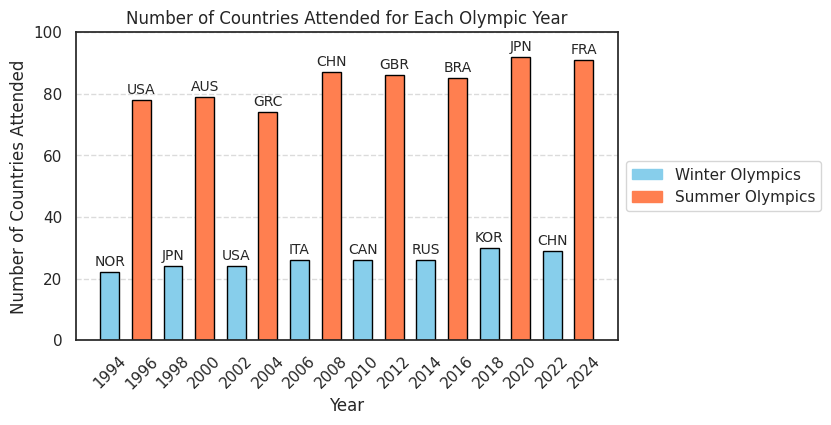

In [7]:
plt.figure(figsize=(7, 4))

threshold = 50

bars = plt.bar(
    year_city['Year'].astype(str), 
    year_city['NrCountriesAttended'], 
    color=['skyblue' if x < threshold else 'coral' for x in year_city['NrCountriesAttended']], 
    edgecolor='black',
    width=0.6
)

plt.xlabel('Year')
plt.ylabel('Number of Countries Attended')
plt.title('Number of Countries Attended for Each Olympic Year')
plt.xticks(rotation=45)
plt.ylim((0, 100))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the country code.
for bar, code in zip(bars, year_city['CountryAlpha3']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2, code, ha='center', fontsize=10)

# Show in the legend what is winter and what summer olympics.
handles = [plt.Rectangle((0, 0), 1, 1, color='skyblue'),
           plt.Rectangle((0, 0), 1, 1, color='coral')]
labels = ['Winter Olympics', 'Summer Olympics']
plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

- No olympic games were hosted in 2008.
- The olympics with the smaller `Number of Countries Attended` are the winter olympics.
    - Generally above $20$ and below $30$ countries attended the winter olympics.
- The olympics with the higher `Number of Countries Attended` are the summer olympics. 
    - Generally above $70$ and below $1000$ countries attended the summer olympics.

# 🥉 Deep Dive into Medals 

In this section we dive deep into medal related distributions.

In [8]:
# --- For easier coding we will now replace the city key with the Alpha3 country code ---

city_to_country_alpha3 = dict(zip(year_city["City"], year_city["CountryAlpha3"]))

olympics = {
    (year, city_to_country_alpha3[city]): value
    for (year, city), value in _olympics.items()
}

olympics.get((1994, 'NOR')).head(3)

,NOC,Gold,Silver,Bronze,Total
0,RUS,11,8,4,23
1,NOR,10,11,5,26
2,GER,9,7,8,24


## Total Medals Over Time

We start by checking how many gold, silver and bronze medals there are per year. How much did this number change over time? 

In [9]:
year_city['TotalMedals'] = 0
year_city['TotalMedalsGold'] = 0
year_city['TotalMedalsSilver'] = 0
year_city['TotalMedalsBronze'] = 0

for year_host, data in olympics.items():
    year_city.loc[year_city['Year'] == year_host[0], 'TotalMedals'] = data['Total'].sum()
    year_city.loc[year_city['Year'] == year_host[0], 'TotalMedalsGold'] = data['Gold'].sum()
    year_city.loc[year_city['Year'] == year_host[0], 'TotalMedalsSilver'] = data['Silver'].sum()
    year_city.loc[year_city['Year'] == year_host[0], 'TotalMedalsBronze'] = data['Bronze'].sum()
    
year_city

,Year,City,Country,CountryAlpha3,CountryFlag,NrCountriesAttended,TotalMedals,TotalMedalsGold,TotalMedalsSilver,TotalMedalsBronze
0,1994,Lillehammer,Norway,NOR,🇳🇴,22,183,61,61,61
1,1996,Atlanta,United States,USA,🇺🇸,78,841,271,273,297
2,1998,Nagano,Japan,JPN,🇯🇵,24,205,69,68,68
3,2000,Sydney,Australia,AUS,🇦🇺,79,926,300,300,326
4,2002,SaltLakeCity,United States,USA,🇺🇸,24,234,80,76,78
5,2004,Athens,Greece,GRC,🇬🇷,74,929,301,301,327
6,2006,Torino,Italy,ITA,🇮🇹,26,252,84,84,84
7,2008,Beijing,China,CHN,🇨🇳,87,958,302,303,353
8,2010,Vancouver,Canada,CAN,🇨🇦,26,258,86,87,85
9,2012,London,United Kingdom,GBR,🇬🇧,86,961,303,305,353


In [10]:
# ------------------------ #
# Helper plotting function #
# ------------------------ #

def plot_total_medal_distribution(medal_col, x_label):
    plt.figure(figsize=(7, 4))

    threshold = 50

    bars = plt.bar(
        year_city['Year'].astype(str), 
        year_city['TotalMedals'], 
        color=['skyblue' if x < threshold else 'coral' for x in year_city['NrCountriesAttended']], 
        edgecolor='black',
        width=0.6
    )

    plt.xlabel('Year')
    plt.ylabel(f'{x_label}')
    plt.title(f'{x_label} for Each Olympic Year')
    plt.ylim((0, 1_200))
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Show the country code.
    for bar, code in zip(bars, year_city['CountryAlpha3']):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 20, code, ha='center', fontsize=10)

    # Show in the legend what is winter and what summer olympics.
    handles = [plt.Rectangle((0, 0), 1, 1, color='skyblue'),
               plt.Rectangle((0, 0), 1, 1, color='coral')]
    labels = ['Winter Olympics', 'Summer Olympics']
    plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()    

                                   🥇🥈🥉


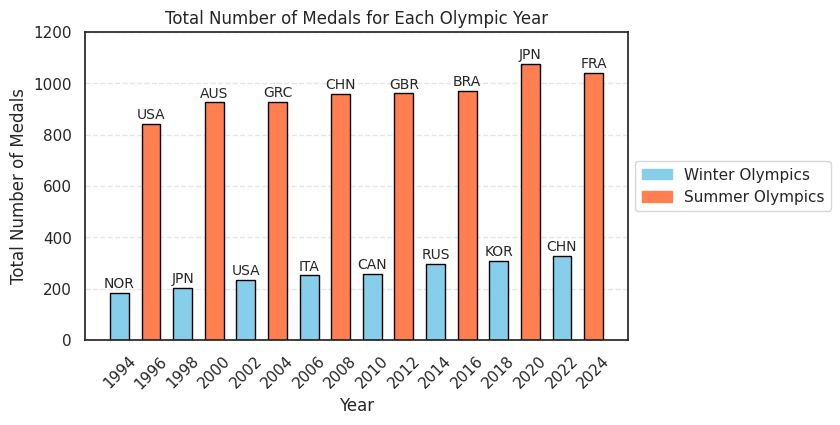

In [11]:
# -------------------------------- #
# Total number of medals over time #
# -------------------------------- #

print(f"{35*' '}🥇🥈🥉")

plot_total_medal_distribution('TotalMedals', 'Total Number of Medals')

- __Summer Olympics__: 
    - There is a clear increasing trend in the total number of medals awarded for the Summer Olympics up until 2020, indicating a growth in participation and/or the number of events.
    - However, the Olympics in 🇫🇷 France 2024 are the only ones which break the trend due to less over all medals compared to the previous summer olympics in 🇯🇵 Japan 2020.
- __Winter Olympics__: 
    - The total number of medals for the Winter Olympics shows a steady increase from 1994 onwards, reflecting consistent growth over the years.
    
Overall the increase in medals over time seems to be stronger for the Summer Olympics than for the Winter Olympics. This indicates that in general, more disciplines are getting added to the Summer Olympics.

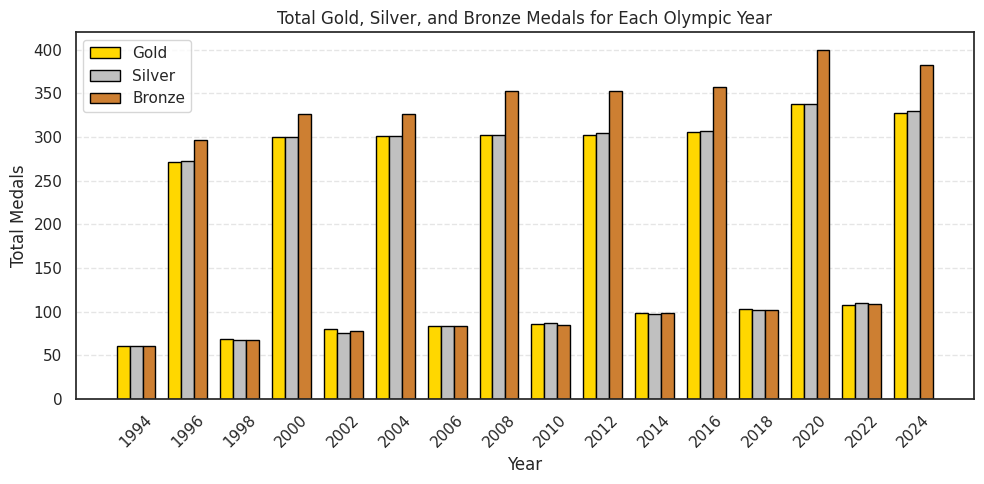

In [12]:
# ---------------------------------------------------- #
# Gold, Silver and Bronze medal distribution over time #
# ---------------------------------------------------- #

positions = range(len(year_city))
bar_width = 0.25

plt.figure(figsize=(10, 5))

plt.bar([p - bar_width for p in positions], year_city['TotalMedalsGold'], width=bar_width, color='gold', edgecolor='black', label='Gold')
plt.bar(positions, year_city['TotalMedalsSilver'], width=bar_width, color='silver', edgecolor='black', label='Silver')
plt.bar([p + bar_width for p in positions], year_city['TotalMedalsBronze'], width=bar_width, color='#cd7f32', edgecolor='black', label='Bronze')

plt.xlabel('Year')
plt.ylabel('Total Medals')
plt.title('Total Gold, Silver, and Bronze Medals for Each Olympic Year')
plt.xticks(positions, year_city['Year'], rotation=45)

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

- Except for the first year 1994 there is always a slight discrepancy between the total number of gold 🥇, silver 🥈 and bronze 🥉 medals.
- For all the Summer Olympics, the number of bronze 🥉 medals is always larger then the number of gold and silver medals.
    - However, this trend is not visible for the Winter Olympics.

# 🗺️ Deep Dive into Countries

In this section we are going to investigate the distribution of medals per country. We start by creating a dataframe which contains per country which attended the total number of medals. 

In [13]:
# ------------------------------------------------ #
# Calculate the total number of medals per country #
# and per country per olympic year                 #
# ------------------------------------------------ #

data = []
for (year, host), df in olympics.items():
    df['Year'] = year
    df['Host'] = host
    data.append(df)

df = pd.concat(data).reset_index(drop=True)

overall_medals = df.groupby('NOC').agg({
    'Gold': 'sum',
    'Silver': 'sum',
    'Bronze': 'sum'
}).reset_index()

overall_medals['Total'] = overall_medals['Gold'] + overall_medals['Silver'] + overall_medals['Bronze']
yearly_medals = df.pivot_table(index='NOC', columns='Year', values='Total', aggfunc='sum', fill_value=0)

country_summary = overall_medals.set_index('NOC').join(yearly_medals)
country_summary = country_summary.reset_index().sort_values(['Total'], ascending=False).reset_index(drop=True)

nr_countries_in_the_world = 195
print(f"Number of countries: {country_summary.shape[0]}, which is {100*country_summary.shape[0]/nr_countries_in_the_world:0.2f} % of all countries in the world.")
country_summary.head(10)

Number of countries: 141, which is 72.31 % of all countries in the world.


,NOC,Gold,Silver,Bronze,Total,1994,1996,1998,2000,2002,...,2006,2008,2010,2012,2014,2016,2018,2020,2022,2024
0,USA,392,354,323,1069,13,101,13,93,34,...,25,112,37,104,28,121,23,113,25,126
1,CHN,289,214,185,688,3,50,8,58,8,...,11,100,11,92,9,70,9,89,15,91
2,GER,200,199,193,592,24,65,29,56,36,...,29,41,30,44,19,42,31,37,27,33
3,RUS,194,164,185,543,23,63,18,89,13,...,22,60,15,65,29,56,0,0,0,0
4,FRA,118,140,155,413,5,37,8,38,11,...,9,43,11,35,15,42,15,33,14,64
5,GBR,137,126,141,404,2,15,1,28,2,...,1,51,1,65,5,67,5,64,2,65
6,AUS,113,124,140,377,1,41,1,58,2,...,2,46,3,35,3,29,3,46,4,53
7,ITA,106,109,144,359,20,35,10,34,13,...,11,27,5,28,9,28,10,40,17,40
8,JPN,114,101,123,338,5,14,10,18,2,...,1,25,5,38,8,41,13,58,18,45
9,CAN,96,109,129,334,13,22,15,14,17,...,24,20,26,18,25,22,29,24,26,27


Now we have a dataframe which contains information about the total number of medals won by each country as well as the total number of medals won per country per Olympic year. In total $136$ distinct countries attended summer and/or winter olympics. There are $195$ countries in the world. Thus, nearly $70$% of all countries in the world attended the olympics at least once in the last $30$ years. 

In the following we will investigate the distribution of medals per country.

## Overall Medals per Country

In this section we will start by taking a look at the overall ranking of medals per country, independent of the year. 

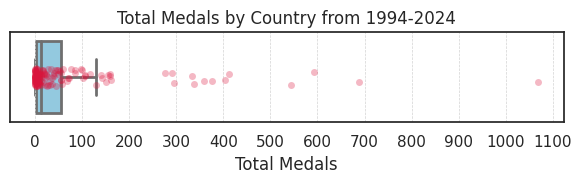

In [14]:
plt.figure(figsize=(6, 2))
sns.boxplot(data=country_summary, x='Total', color='skyblue', showfliers=False, linewidth=2)
sns.stripplot(data=country_summary, x='Total', color='crimson', alpha=0.3)

plt.title('Total Medals by Country from 1994-2024')
plt.xlabel('Total Medals')
plt.xticks(range(0, max(country_summary['Total']) + 100, 100))
for x in range(0, max(country_summary['Total']) + 100, 100):
    plt.axvline(x=x, color='lightgrey', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

- The majority of countries has largely less then $100$ overall medals.
- There are only some outliers, and those have hundreds of medals up to nearly $1,000$ over medals for a country.

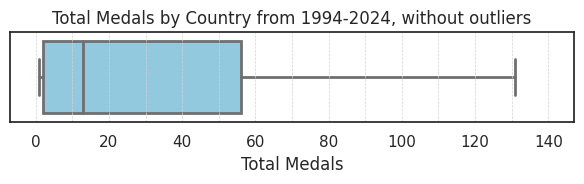

count     141.000000
mean       69.241135
std       146.360363
min         1.000000
25%         2.000000
50%        13.000000
75%        56.000000
max      1069.000000
Name: Total, dtype: float64


In [15]:
plt.figure(figsize=(6, 2))
sns.boxplot(data=country_summary, x='Total', color='skyblue', showfliers=False, linewidth=2)

plt.title('Total Medals by Country from 1994-2024, without outliers')
plt.xlabel('Total Medals')
for x in range(0, 150, 10):
    plt.axvline(x=x, color='lightgrey', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

print(country_summary['Total'].describe())

- `IQR` (25%-50%): Taking a closer look at the distribution without outliers, we clearly see that $50$% of all counties won between $2$ and $54$ medals.
- `Mean`: On average a country has gotten $64$ medals between 1994 and 2024. But not that the average is highly sensitive to outliers, which we saw previously are significant.
- `Median` (50%): $50$% of all countries have gotten below $12$ medals, and $50$% of all countries have gotten above $12$ medals.
- `Q3` (75%): The upper quartile is at roughly $55$, which indicates that $25$% of all countries have more then $55$ over medals in $30$ years.

## Medals over the Years

In this section we are going to take a look at the distribution of overall medals over the years. 

In [16]:
melted_df = country_summary.melt(id_vars=['NOC', 'Gold', 'Silver', 'Bronze', 'Total'], 
                                 var_name='Year', 
                                 value_name='YearlyTotalMedals')
melted_df.head(3)

,NOC,Gold,Silver,Bronze,Total,Year,YearlyTotalMedals
0,USA,392,354,323,1069,1994,13
1,CHN,289,214,185,688,1994,3
2,GER,200,199,193,592,1994,24


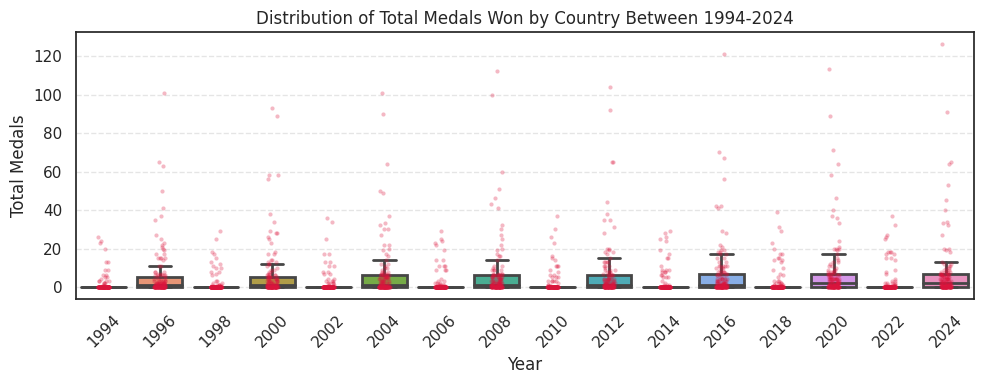

In [17]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=melted_df, x='Year', y='YearlyTotalMedals', showfliers=False, linewidth=2)
sns.stripplot(data=melted_df, x='Year', y='YearlyTotalMedals', color='crimson', size=3, alpha=0.3)

plt.title('Distribution of Total Medals Won by Country Between 1994-2024')
plt.xlabel('Year')
plt.ylabel('Total Medals')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

- When distinguishing between summer and winter olympics, the distribution of total medals appears fairly consistent across the years, with a similar median and spread of data points. 
- This suggests, that generally the number of won medals per country is similar, with most countries having small numbers of won medals and a small number of outliers win significantly more.

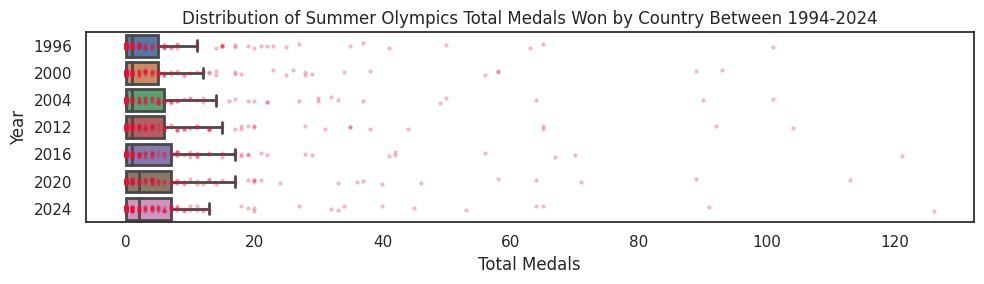

In [18]:
summer_olympics_years = [1996, 2000, 2004, 2012, 2016, 2020, 2024]
summer_olympics_df = melted_df[melted_df['Year'].isin(summer_olympics_years)]

plt.figure(figsize=(10, 3))
sns.boxplot(data=summer_olympics_df, y='Year', x='YearlyTotalMedals', showfliers=False, linewidth=2, orient='h')
sns.stripplot(data=summer_olympics_df, y='Year', x='YearlyTotalMedals', color='crimson', size=3, alpha=0.3, orient='h')

plt.title('Distribution of Summer Olympics Total Medals Won by Country Between 1994-2024')
plt.ylabel('Year')
plt.xlabel('Total Medals')

plt.tight_layout()
plt.show()

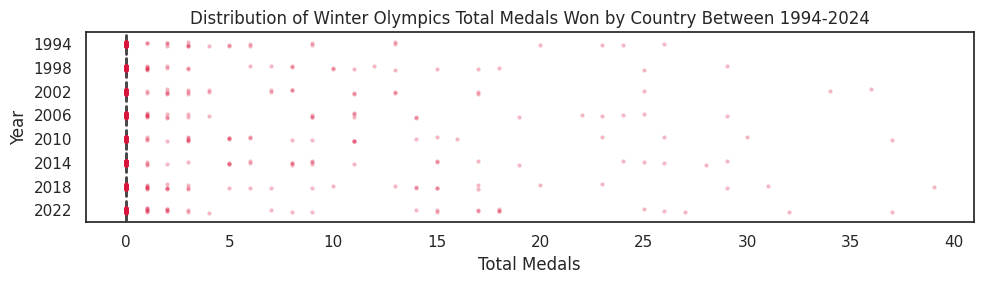

In [19]:
winter_olympics_years = [1994, 1998, 2002, 2006, 2010, 2014, 2018, 2022]
winter_olympics_df = melted_df[melted_df['Year'].isin(winter_olympics_years)]

plt.figure(figsize=(10, 3))
sns.boxplot(data=winter_olympics_df, y='Year', x='YearlyTotalMedals', showfliers=False, linewidth=2, orient='h')
sns.stripplot(data=winter_olympics_df, y='Year', x='YearlyTotalMedals', color='crimson', size=3, alpha=0.3, orient='h')

plt.title('Distribution of Winter Olympics Total Medals Won by Country Between 1994-2024')
plt.ylabel('Year')
plt.xlabel('Total Medals')

plt.tight_layout()
plt.show()

Since the majority of countries in the winter olympics seem to not win any medals we focus on the summer olympics in the following. 

## Medals over the Years, by Medal Type

In this section we are going to take a look at the distribution of Gold, Silver and Bronze medals over the years. 

In [20]:
# ------------------------------------------------ #
# Calculate the total number of medals per country #
# and per country per olympic year for a           #
# specific model type#                             #
# ------------------------------------------------ #

def get_country_summary_per_modeltype(olympics, model_type):
    data = []
    for (year, host), df in olympics.items():
        df['Year'] = year
        df['Host'] = host
        data.append(df)

    df = pd.concat(data).reset_index(drop=True)

    overall_medals = df.groupby('NOC').agg({
        'Gold': 'sum',
        'Silver': 'sum',
        'Bronze': 'sum'
    }).reset_index()

    yearly_medals = df.pivot_table(index='NOC', columns='Year', values=model_type, aggfunc='sum', fill_value=0)

    country_summary = overall_medals.set_index('NOC').join(yearly_medals)
    country_summary = country_summary.reset_index().sort_values([model_type], ascending=False).reset_index(drop=True)
    
    country_summary['ModelType'] = model_type

    return country_summary[['NOC', 'ModelType'] + GlobalVars.ALL_YEARS]

In [21]:
# Count medals per country per year by model type.
country_summary_gold = get_country_summary_per_modeltype(olympics, 'Gold')
country_summary_silver = get_country_summary_per_modeltype(olympics, 'Silver')
country_summary_bronze = get_country_summary_per_modeltype(olympics, 'Bronze')

# Add all model types together.
country_summary_gold_silver_bronze = pd.concat([country_summary_gold, country_summary_silver, country_summary_bronze], axis=0, ignore_index=True)

country_summary_gold_silver_bronze

,NOC,ModelType,1994,1996,1998,2000,2002,2004,2006,2008,2010,2012,2014,2016,2018,2020,2022,2024
0,USA,Gold,6,44,6,37,10,36,9,36,9,48,9,46,9,39,8,40
1,CHN,Gold,0,16,0,28,2,32,2,48,5,39,3,26,1,38,9,40
2,GER,Gold,9,20,12,13,12,13,11,16,10,11,8,17,14,10,12,12
3,RUS,Gold,11,26,9,32,5,28,8,24,3,18,11,19,0,0,0,0
4,GBR,Gold,0,1,0,11,1,9,0,19,1,29,1,27,1,22,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,MNE,Bronze,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
419,PAR,Bronze,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
420,PAN,Bronze,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
421,PAK,Bronze,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
melted_df = country_summary_gold_silver_bronze.melt(id_vars=['NOC', 'ModelType'], 
                                                    var_name='Year', 
                                                    value_name='YearlyMedals')
melted_df.head(3)

,NOC,ModelType,Year,YearlyMedals
0,USA,Gold,1994,6
1,CHN,Gold,1994,0
2,GER,Gold,1994,9


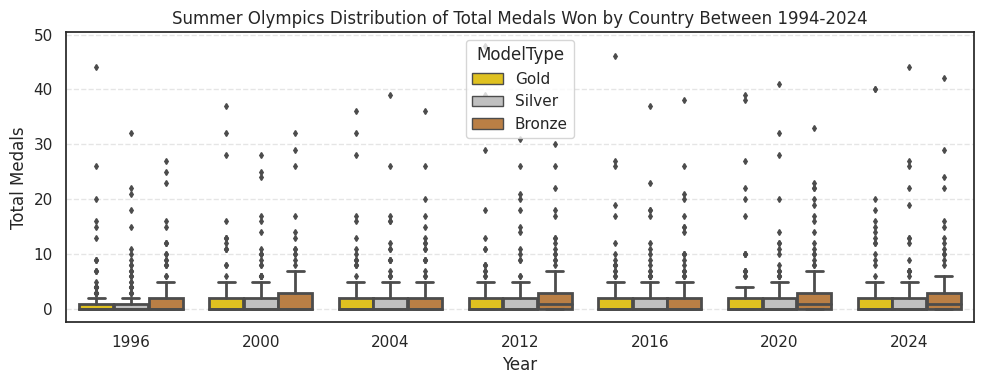

In [23]:
plt.figure(figsize=(10, 4))

summer_df = melted_df[melted_df['Year'].isin(GlobalVars.SUMMER_YEARS)]

color_palette = {
    'Gold': 'Gold',
    'Silver': 'Silver',
    'Bronze': '#cd7f32'
}

sns.boxplot(data=summer_df, x='Year', y='YearlyMedals', hue='ModelType', showfliers=True, fliersize=3, linewidth=2, palette=color_palette)
# sns.stripplot(data=melted_df, x='Year', y='YearlyTotalMedals', color='crimson', size=3, alpha=0.3)

plt.title('Summer Olympics Distribution of Total Medals Won by Country Between 1994-2024')
plt.xlabel('Year')
plt.ylabel('Total Medals')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

- As before seen, the general distribution of won medals per country (the boxes) are pretty similar year-over-year. 
- It also seems like even the outlier countries have a similar behavior. We need to investigate further if these outlier countries are mostly the same countries. 

## Top Performing Countries

In this section we are going to take a look at the performance of each country and try to understand if the top performing countries are similar year-over-year.

In [24]:
melted_df = country_summary.melt(id_vars=['NOC', 'Gold', 'Silver', 'Bronze', 'Total'], 
                                 var_name='Year', 
                                 value_name='YearlyTotalMedals')[['NOC', 'Year', 'YearlyTotalMedals']]
melted_df.head(3)

,NOC,Year,YearlyTotalMedals
0,USA,1994,13
1,CHN,1994,3
2,GER,1994,24


In [25]:
TOP_N = 3

sorted_df = melted_df.sort_values(by=['Year', 'YearlyTotalMedals'], ascending=[True, False])
top_n_countries_per_year = sorted_df.groupby('Year').head(TOP_N).reset_index(drop=True)
top_n_countries_per_year['NOC'] = top_n_countries_per_year['NOC'].replace({'ROC': 'CHN', 'GER': 'DEU'})
top_n_countries_per_year['Rank'] = top_n_countries_per_year\
    .groupby('Year')['YearlyTotalMedals']\
    .rank(ascending=False, method='first')\
    .astype(int)
top_n_countries_per_year.head(6)

,NOC,Year,YearlyTotalMedals,Rank
0,NOR,1994,26,1
1,DEU,1994,24,2
2,RUS,1994,23,3
3,USA,1996,101,1
4,DEU,1996,65,2
5,RUS,1996,63,3


The countries in the plot below have these flags:
   NOC Flag
0  NOR   🇳🇴
1  DEU   🇩🇪
2  RUS   🇷🇺
3  USA   🇺🇸
4  CHN   🇨🇳
5  CAN   🇨🇦
6  GBR   🇬🇧


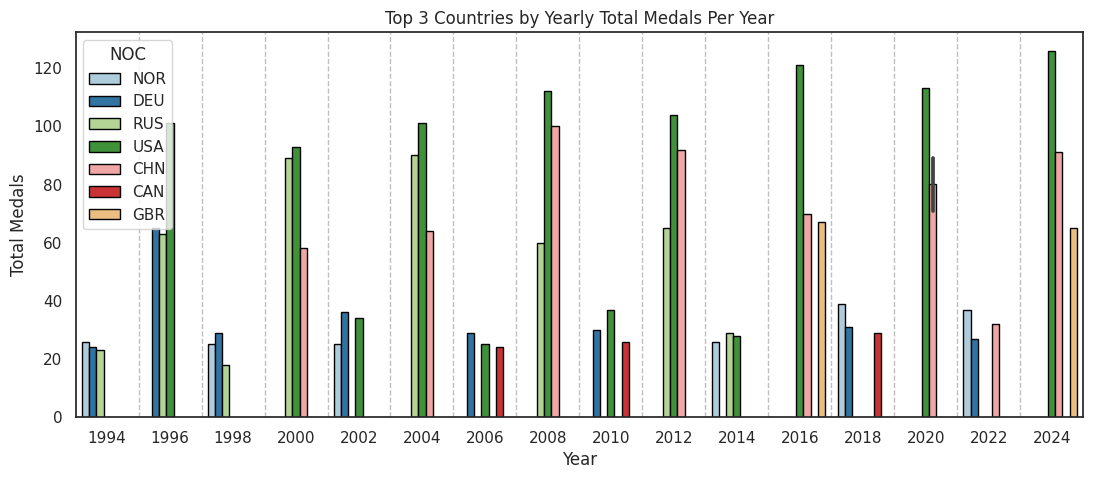

In [26]:
# --------------- #
# Country to flag #
# --------------- #

distinct_countries = top_n_countries_per_year['NOC'].unique().tolist()
flags = [pycountry.countries.get(alpha_3=x).flag for x in distinct_countries]

print("The countries in the plot below have these flags:")
print(pd.DataFrame({'NOC': distinct_countries, 'Flag': flags}))


# ----------------------------- #
# Show top X countries per year #
# ----------------------------- #

plt.figure(figsize=(13, 5))

bars = sns.barplot(
    data=top_n_countries_per_year,
    x='Year',
    y='YearlyTotalMedals',
    hue='NOC',
    palette='Paired',
    dodge=True,
    edgecolor='black',
)

for i in range(len(top_n_countries_per_year['Year'].unique()) - 1):
    plt.axvline(x=i + 0.5, color='grey', linestyle='--', lw=1, alpha=0.5)

plt.xlabel('Year')
plt.ylabel('Total Medals')
plt.title(f'Top {TOP_N} Countries by Yearly Total Medals Per Year')
plt.grid(False)

plt.show()

__Summer Olympics__
- The United States of America 🇺🇸 is under the top $3$ countries with the highest medals in every olympics since $1996$.
    - It is not only under the top $3$, also, __since $1996$ the USA 🇺🇸 has always been the country with the most won medals__.
- For the first $4$ summer olympics Russia 🇷🇺 has also always been in the top $3$.
    - However, since $2016$ they are out of the top $3$.
- Except for the olympics in $1996$, China 🇨🇳 has constantly been in the top $3$.
- In $2016$ and $2024$ Great Britian 🇬🇧 was the country with the 3rd highest number of medals won.

__Winter Olympics__
- The ranking for the winter olympics shows different distributions compared to the summer olympics. 
- Except for $2014$, Germany 🇩🇪 has always been in the top $3$.
    - $2$ ($25$%) out of $8$ times Germany 🇩🇪 was the country who won the most medals.
- Except for $2006$ and $2010$, Norway 🇳🇴 has always been in the top $3$.
    - $2$ ($25$%) out of $8$ times Norway 🇳🇴 was the country who won the most medals.

The countries in the plot below have these flags:
    NOC Flag
0   NOR   🇳🇴
1   DEU   🇩🇪
2   RUS   🇷🇺
3   ITA   🇮🇹
4   USA   🇺🇸
5   CHN   🇨🇳
6   AUS   🇦🇺
7   AUT   🇦🇹
8   CAN   🇨🇦
9   GBR   🇬🇧
10  NLD   🇳🇱
11  JPN   🇯🇵
12  FRA   🇫🇷


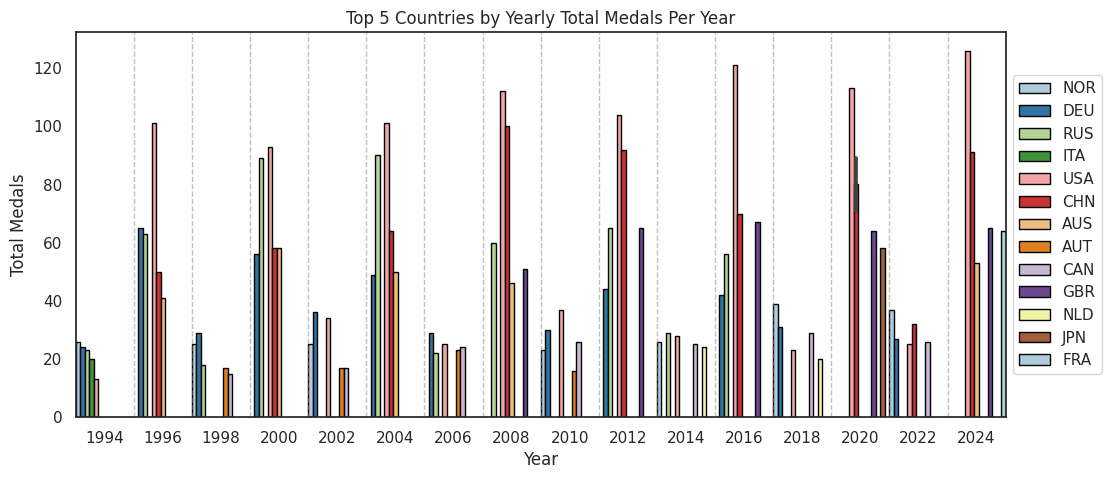

In [27]:
# ------------------- #
# Prepare the dataset #
# ------------------- #

TOP_N = 5

sorted_df = melted_df.sort_values(by=['Year', 'YearlyTotalMedals'], ascending=[True, False])
top_n_countries_per_year = sorted_df.groupby('Year').head(TOP_N).reset_index(drop=True)
top_n_countries_per_year['NOC'] = top_n_countries_per_year['NOC'].replace({'ROC': 'CHN', 'GER': 'DEU', 'NED': 'NLD'})

# --------------- #
# Country to flag #
# --------------- #

distinct_countries = top_n_countries_per_year['NOC'].unique().tolist()
flags = [pycountry.countries.get(alpha_3=x).flag for x in distinct_countries]

print("The countries in the plot below have these flags:")
print(pd.DataFrame({'NOC': distinct_countries, 'Flag': flags}))


# ----------------------------- #
# Show top X countries per year #
# ----------------------------- #

plt.figure(figsize=(12, 5))

bars = sns.barplot(
    data=top_n_countries_per_year,
    x='Year',
    y='YearlyTotalMedals',
    hue='NOC',
    palette='Paired',
    dodge=True,
    edgecolor='black',
    width=1.0,
)

for i in range(len(top_n_countries_per_year['Year'].unique()) - 1):
    plt.axvline(x=i + 0.5, color='grey', linestyle='--', lw=1, alpha=0.5)

plt.xlabel('Year')
plt.ylabel('Total Medals')
plt.title(f'Top {TOP_N} Countries by Yearly Total Medals Per Year')
plt.grid(False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [28]:
TOP_N = 5

# Sort the data by Year and YearlyTotalMedals in descending order.
sorted_df = melted_df.sort_values(by=['Year', 'YearlyTotalMedals'], ascending=[True, False])

# Calculate the total number of medals per year.
total_medals_per_year = sorted_df.groupby('Year')['YearlyTotalMedals'].sum().reset_index()
total_medals_per_year.columns = ['Year', 'TotalMedals']

top_n_countries_per_year = sorted_df.groupby('Year').head(TOP_N).reset_index(drop=True)
top_n_countries_per_year['NOC'] = top_n_countries_per_year['NOC'].replace({'ROC': 'CHN', 'GER': 'DEU'})
top_n_countries_with_totals = pd.merge(top_n_countries_per_year, total_medals_per_year, on='Year')

# Rank for each country per year, depending on the total medals won in that year.
top_n_countries_with_totals['Rank'] = top_n_countries_with_totals.groupby('Year')['YearlyTotalMedals'].rank(ascending=False, method='first').astype(int)

# Calculate the percentage of won medals for the country out of all medals in that year.
top_n_countries_with_totals['PctWonMedals'] = 100 * (top_n_countries_with_totals['YearlyTotalMedals'] / top_n_countries_with_totals['TotalMedals'])

# Calculate the cumulative percentage of how much TOP_N countries together won out of all medals.
top_n_countries_with_totals['CumPctWonMedals'] = top_n_countries_with_totals.groupby('Year')['PctWonMedals'].cumsum()

top_n_countries_with_totals.head(6)

,NOC,Year,YearlyTotalMedals,TotalMedals,Rank,PctWonMedals,CumPctWonMedals
0,NOR,1994,26,183,1,14.207650,14.207650
1,DEU,1994,24,183,2,13.114754,27.322404
2,RUS,1994,23,183,3,12.568306,39.890710
3,ITA,1994,20,183,4,10.928962,50.819672
4,USA,1994,13,183,5,7.103825,57.923497
5,USA,1996,101,841,1,12.009512,12.009512


Using the dataframe from above we can now observe the overall domination strength of the `TOP_N` countries over time. 

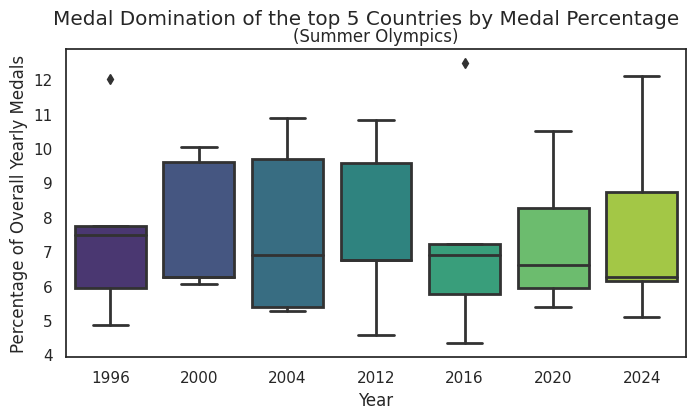

In [29]:
plt.figure(figsize=(8, 4))

sns.boxplot(data=top_n_countries_with_totals[top_n_countries_with_totals['Year'].isin(GlobalVars.SUMMER_YEARS)],
            x='Year',
            y='PctWonMedals',
            linewidth=2, 
            palette='viridis');
plt.suptitle(f'Medal Domination of the top {TOP_N} Countries by Medal Percentage');
plt.title('(Summer Olympics)');
plt.ylabel('Percentage of Overall Yearly Medals');

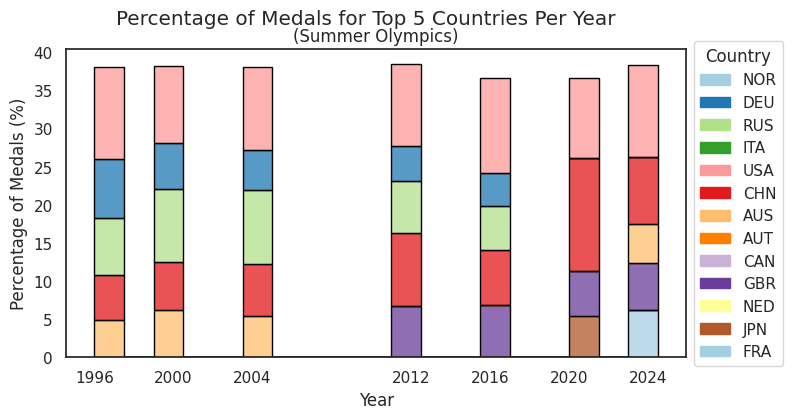

In [30]:
unique_nocs = top_n_countries_with_totals['NOC'].unique()
palette = sns.color_palette("Paired", len(unique_nocs))
color_mapping = dict(zip(unique_nocs, palette))

plt.figure(figsize=(8, 4))

sns.histplot(
    data=top_n_countries_with_totals[top_n_countries_with_totals['Year'].isin(GlobalVars.SUMMER_YEARS)],
    x='Year',
    weights='PctWonMedals',
    hue='NOC',
    multiple='stack',
    palette=color_mapping,
    binwidth=1.5,
    edgecolor='black',
)

plt.xlabel('Year')
plt.ylabel('Percentage of Medals (%)')
plt.suptitle(f'Percentage of Medals for Top {TOP_N} Countries Per Year')
plt.title('(Summer Olympics)')

plt.xticks(GlobalVars.SUMMER_YEARS)
for container in bars.containers:
    bars.bar_label(container, label_type='center')

handles = [plt.Rectangle((0, 0), 1, 1, color=color_mapping[noc]) for noc in unique_nocs]
labels = [noc for noc in unique_nocs]
plt.legend(handles, labels, title="Country", loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

Interestingly, the cumulative percentage of won medals of the top $5$ over time did not change drastically. For all summer olympics since $1996$ it seems to be always slightly below $40$%. 

> That shows that the top $5$ countries always win a similar amount of overall medals. 

--- 


💚 Thank you for reading 💚

- If you have any questions or feedback, feel free to leave a comment 🤔
- Please __UPVOTE__ if you enjoyed this notebook 🙏